# Closed Funnel 封闭漏斗
* user_pseudo_id is not a session id. It´s a unique ID "by app install". So as long as a user uses the same App-Instance ("Installation") without reinstalling it, the user_pseudo_id stays the same. It also don´t change on App update. But it will change if you uninstall and reinstall the app.

In [ ]:
%load_ext google.cloud.bigquery
%load_ext google.colab.data_table
project_id='your-project-id' #@param{type:"string"}

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery
The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


In [ ]:
#@title Auth with your account, click the link.
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


-- query all event where event_name is session_start or add_to_cart. 

-- also fetch user_pseduo_id and event_timestamp columns 

In [ ]:
%%bigquery --project {project_id}
SELECT event_name, user_pseudo_id , event_timestamp 
FROM `bingo-blast-174dd.analytics_151321511.events_20200607` 
WHERE (event_name = "session_start" OR event_name = "level_up")
ORDER BY 2,3
limit 200;

,event_name,user_pseudo_id,event_timestamp
0,session_start,0073ebfd5ed378f962a27e53b24547e7,1591552048916000
1,level_up,0073ebfd5ed378f962a27e53b24547e7,1591552283235000
2,session_start,009BA9A852504AF3A641540C0BB6D035,1591527425933000
3,session_start,009BA9A852504AF3A641540C0BB6D035,1591544004696000
4,session_start,01418E873376464EB4A0E4473D0FE296,1591513723826000
...,...,...,...
195,session_start,15A10CE7884847CF97EDD588D06232D5,1591525302465000
196,level_up,15f738ab1ebb2e5aabfc9bdcd06832a9,1591510231001000
197,session_start,15f738ab1ebb2e5aabfc9bdcd06832a9,1591510385595000
198,session_start,163b5fb7dedd2ff5841e273f20525f52,1591490986520000


In [ ]:
%%bigquery --project chris-demo-258505
SELECT event_name, user_pseudo_id , event_timestamp,
-- add “next_event” -
LEAD(event_name, 1) OVER (PARTITION BY user_pseudo_id ORDER BY event_timestamp) AS next_event
FROM `bingo-blast-174dd.analytics_151321511.events_20200607`
WHERE (event_name = "session_start" OR event_name = "level_up")
ORDER BY 2,3
limit 5;

,event_name,user_pseudo_id,event_timestamp,next_event
0,session_start,0073ebfd5ed378f962a27e53b24547e7,1591552048916000,level_up
1,level_up,0073ebfd5ed378f962a27e53b24547e7,1591552283235000,None
2,session_start,009BA9A852504AF3A641540C0BB6D035,1591527425933000,session_start
3,session_start,009BA9A852504AF3A641540C0BB6D035,1591544004696000,None
4,session_start,01418E873376464EB4A0E4473D0FE296,1591513723826000,None


In [ ]:
%%bigquery --project chris-demo-258505
SELECT 
IF (event_name = "session_start", 1, 0) AS funnel_1, 
IF (event_name = "session_start" AND next_event = "level_up", 1, 0) AS funnel_2 
FROM ( 
	SELECT event_name, user_pseudo_id , event_timestamp, 
	LEAD(event_name, 1) OVER (PARTITION BY user_pseudo_id ORDER BY event_timestamp) AS next_event
	FROM `bingo-blast-174dd.analytics_151321511.events_20200607` 
	WHERE (event_name = "session_start" OR event_name = "level_up") 
	ORDER BY 2,3 
)
limit 5

,funnel_1,funnel_2
0,1,1
1,0,0
2,1,0
3,1,0
4,1,0


In [ ]:
%%bigquery --project chris-demo-258505
SELECT 
   SUM (IF (event_name = "session_start", 1, 0)) AS funnel_1_total, 
   SUM (IF (event_name = "session_start" AND next_event = "level_up", 1, 0)) AS funnel_2_total
   FROM ( 
      SELECT event_name, user_pseudo_id , event_timestamp, 
      LEAD(event_name, 1) OVER (PARTITION BY user_pseudo_id ORDER BY event_timestamp) AS next_event 
      FROM `bingo-blast-174dd.analytics_151321511.events_20200607` 
      WHERE (event_name = "session_start" OR event_name = "level_up") 
      ORDER BY 2,3 
   )

,funnel_1_total,funnel_2_total
0,1715,282


In [ ]:
%%bigquery --project chris-demo-258505
SELECT 
  count(distinct funnel_1) as funnel_1_total, 
  count(distinct funnel_2) as funnel_2_total 
FROM
( 
  SELECT 
    -- If true: 1, false: 0 -> If true: user_pseudo_id, false: NULL 
    IF (event_name = "session_start", user_pseudo_id, NULL) AS funnel_1,
    IF (event_name = "session_start" AND next_event = "level_up", user_pseudo_id, NULL) AS funnel_2
    FROM 
    ( 
      SELECT event_name, user_pseudo_id , event_timestamp, 
      LEAD(event_name, 1) OVER (PARTITION BY user_pseudo_id ORDER BY event_timestamp) AS next_event 
      FROM `bingo-blast-174dd.analytics_151321511.events_20200607` 
      WHERE (event_name = "session_start" OR event_name = "level_up") 
      ORDER BY 2,3 
    )
)
limit 5;

,funnel_1_total,funnel_2_total
0,827,208


In [ ]:
%%bigquery --project chris-demo-258505
SELECT count(distinct funnel_1) as funnel_1_total, count(distinct funnel_2) as funnel_2_total from (
  SELECT
  IF (event_name = "session_start", user_pseudo_id, NULL) AS funnel_1, 
  -- 5 minutes between 2 events. time_stemp is in microseconds  
  IF (event_name = "session_start" AND next_event = "level_up" 
     AND next_timestamp - event_timestamp < 5 * 60 * 1000 * 1000, user_pseudo_id, NULL) AS funnel_2
  FROM ( 
    SELECT event_name, user_pseudo_id , event_timestamp, 
    LEAD(event_name, 1) OVER (PARTITION BY user_pseudo_id ORDER BY event_timestamp) AS next_event, 
    -- add next_timestemp  
    LEAD(event_timestamp, 1) OVER (PARTITION BY user_pseudo_id ORDER BY event_timestamp) AS next_timestamp
    FROM `bingo-blast-174dd.analytics_151321511.events_20200607` 
    WHERE (event_name = "session_start" OR event_name = "level_up") 
    ORDER BY 2,3 
  ) 
)

,funnel_1_total,funnel_2_total
0,827,92


In [ ]:
%%bigquery --project chris-demo-258505
SELECT count(distinct funnel_1) as funnel_1_total, count(distinct funnel_2) as funnel_2_total from (
  SELECT 
    IF (event_name = "session_start", user_pseudo_id, NULL) AS funnel_1,  
    IF (event_name = "session_start" AND next_event = "level_up" AND next_timestamp - event_timestamp < 5 * 60 * 1000 * 1000, user_pseudo_id, NULL) AS funnel_2
  FROM ( 
    SELECT event_name, user_pseudo_id , event_timestamp, 
    LEAD(event_name, 1) OVER (PARTITION BY user_pseudo_id ORDER BY event_timestamp) AS next_event, 
    LEAD(event_timestamp, 1) OVER (PARTITION BY user_pseudo_id ORDER BY event_timestamp) AS next_timestamp
    FROM `bingo-blast-174dd.analytics_151321511.events_*` 
    WHERE ((event_name = "session_start" OR event_name = "level_up") AND 
    -- add interval  
       _TABLE_SUFFIX BETWEEN FORMAT_DATE("%Y%m%d", DATE_SUB(CURRENT_DATE(), INTERVAL 360 DAY)) 
    AND FORMAT_DATE("%Y%m%d", CURRENT_DATE())) 
    ORDER BY 2,3 
  ) 
)

,funnel_1_total,funnel_2_total
0,50598,23862


# Retention 留存

This might be better, say daylight time saving? I am not sure actually.

TIMESTAMP("2019-12-28 00:00:00", "Asia/Shanghai") 
以周留存为例，调整时间即可变成日留存或者月留存

In [ ]:
%%bigquery --project chris-demo-258505 df
WITH analytics_data AS (
  SELECT user_pseudo_id, event_timestamp, event_name, 
    UNIX_MICROS(TIMESTAMP("2020-05-01 00:00:00", "+8:00")) AS start_day,
    3600*1000*1000*24*7 AS one_week_micros
  FROM `bingo-blast-174dd.analytics_151321511.events_*`
  WHERE _table_suffix BETWEEN '20200430' AND '20200529'
)

SELECT week_0_cohort / week_0_cohort AS week_0_pct,
 week_1_cohort / week_0_cohort AS week_1_pct,
 week_2_cohort / week_0_cohort AS week_2_pct,
 week_3_cohort / week_0_cohort AS week_3_pct
FROM (
  WITH week_3_users AS (
    SELECT DISTINCT user_pseudo_id
    FROM analytics_data
    WHERE event_timestamp BETWEEN start_day+(3*one_week_micros) AND start_day+(4*one_week_micros)
  ),
  week_2_users AS (
    SELECT DISTINCT user_pseudo_id
    FROM analytics_data
    WHERE event_timestamp BETWEEN start_day+(2*one_week_micros) AND start_day+(3*one_week_micros)
  ),
  week_1_users AS (
    SELECT DISTINCT user_pseudo_id
    FROM analytics_data
    WHERE event_timestamp BETWEEN start_day+(1*one_week_micros) AND start_day+(2*one_week_micros)
  ), 
  week_0_users AS (
    SELECT DISTINCT user_pseudo_id
    FROM analytics_data
    WHERE event_name = 'first_open'
      AND event_timestamp BETWEEN start_day AND start_day+(1*one_week_micros)
  )
  SELECT 
    (SELECT count(*) 
     FROM week_0_users) AS week_0_cohort,
    (SELECT count(*) 
     FROM week_1_users 
     JOIN week_0_users USING (user_pseudo_id)) AS week_1_cohort,
    (SELECT count(*) 
     FROM week_2_users 
     JOIN week_0_users USING (user_pseudo_id)) AS week_2_cohort,
    (SELECT count(*) 
     FROM week_3_users 
     JOIN week_0_users USING (user_pseudo_id)) AS week_3_cohort
)


In [ ]:
df.head()

,week_0_pct,week_1_pct,week_2_pct,week_3_pct
0,1.0,0.247433,0.12115,0.084189


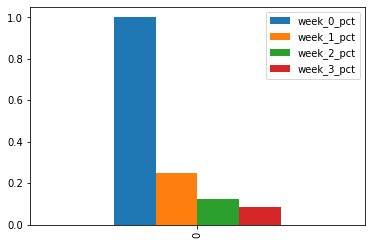

In [ ]:
%matplotlib inline
df.plot(kind='bar');

Something Firebase cannot do

Retention on a specific version 根据app版本细分
This is a bit tricky since we only limited the user for week_0 to deal with upgrades. Adjust according to your business, let's only get the idea :)

In [ ]:
%%bigquery --project chris-demo-258505
WITH analytics_data AS (
  SELECT user_pseudo_id, event_timestamp, event_name, 
    app_info.version AS app_version,   -- This is new!
    UNIX_MICROS(TIMESTAMP("2020-05-01 00:00:00", "+8:00")) AS start_day,
    3600*1000*1000*24*7 AS one_week_micros
  FROM `bingo-blast-174dd.analytics_151321511.events_*`
  WHERE _table_suffix BETWEEN '20200430' AND '20200529'
)

SELECT week_0_cohort / week_0_cohort AS week_0_pct,
 week_1_cohort / week_0_cohort AS week_1_pct,
 week_2_cohort / week_0_cohort AS week_2_pct,
 week_3_cohort / week_0_cohort AS week_3_pct
FROM (
  WITH week_3_users AS (
    SELECT DISTINCT user_pseudo_id
    FROM analytics_data
    WHERE event_timestamp BETWEEN start_day+(3*one_week_micros) AND start_day+(4*one_week_micros)
  ),
  week_2_users AS (
    SELECT DISTINCT user_pseudo_id
    FROM analytics_data
    WHERE event_timestamp BETWEEN start_day+(2*one_week_micros) AND start_day+(3*one_week_micros)
  ),
  week_1_users AS (
    SELECT DISTINCT user_pseudo_id
    FROM analytics_data
    WHERE event_timestamp BETWEEN start_day+(1*one_week_micros) AND start_day+(2*one_week_micros)
  ), 
  week_0_users AS (
    SELECT DISTINCT user_pseudo_id
    FROM analytics_data
    WHERE event_name = 'first_open'
      AND app_version = '1.9.69'   -- This bit is new, too!
      AND event_timestamp BETWEEN start_day AND start_day+(1*one_week_micros)
  )
  SELECT 
    (SELECT count(*) 
     FROM week_0_users) AS week_0_cohort,
    (SELECT count(*) 
     FROM week_1_users 
     JOIN week_0_users USING (user_pseudo_id)) AS week_1_cohort,
    (SELECT count(*) 
     FROM week_2_users 
     JOIN week_0_users USING (user_pseudo_id)) AS week_2_cohort,
    (SELECT count(*) 
     FROM week_3_users 
     JOIN week_0_users USING (user_pseudo_id)) AS week_3_cohort
)

,week_0_pct,week_1_pct,week_2_pct,week_3_pct
0,1.0,0.191111,0.082222,0.063704
